<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 5, 2020, 23:59</center></h1>

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset). **Please use the train and test matrices we prepared for you :)**

In [62]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns

In [63]:
boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(1)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
del X, y, X_y

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

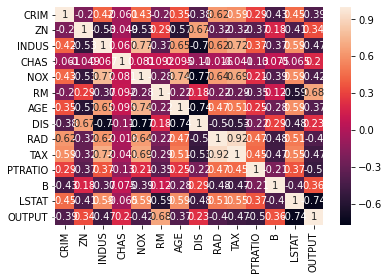

In [64]:
#stack all the features and the outputs with np.column_stack
#this will produce (400,14) ndarray from (400,13) and (400,) , X_train and y_train respectively
singleFeatureOutputStack =  np.column_stack((X_train,y_train))

#calculating correlation coefficient matrix with np.corrcoef
correlationCoefficientMatrix = np.corrcoef(singleFeatureOutputStack,rowvar=False)
heatmap_names = np.append(boston.feature_names,np.array("OUTPUT"))
#plotting heatmap with correlaction coefficient scores
ax = sns.heatmap(correlationCoefficientMatrix, annot=True,xticklabels=heatmap_names, yticklabels=heatmap_names)
ax

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

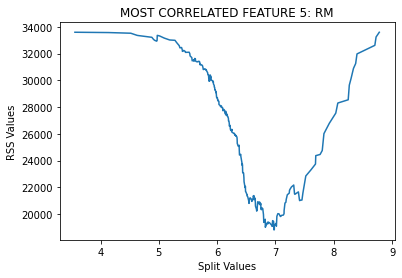

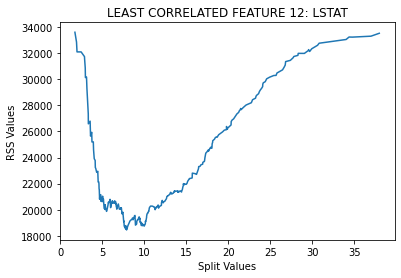

In [66]:
import matplotlib.pyplot as plt
#calculating RSS with respect to values bigger than or equal to splitting criteria's value of feature (right values)
#and less than splitting criteria's value of feature (left values)
def calculateRSS(leftValuesAndLabels,rightValuesAndLabels):
    if len(rightValuesAndLabels) == 0:
        sumOfSquaresRight = 0
    else:
        rightLabels = np.array(list(zip(*rightValuesAndLabels))[1])
        sumOfSquaresRight = np.sum((rightLabels-rightLabels.mean())**2 )
        
    if len(leftValuesAndLabels) == 0:
        sumOfSquaresLeft = 0
    else:
        leftLabels = np.array(list(zip(*leftValuesAndLabels))[1])
        sumOfSquaresLeft = np.sum((leftLabels-leftLabels.mean())**2 )    
        
    rss = sumOfSquaresLeft + sumOfSquaresRight
    return rss

#calculating minimum RSS values of a feature with respect to candidate unique splitting values of a feature
#returns splitting criteria value which gives minimum RSS score and its RSS score
def createLeftAndRightCandidates(featureColumn,candidateSplitValues,train_data, train_label):
    
    minSplitValueAndMinRss = (None,np.inf)
    for candidateValue in candidateSplitValues: 
        leftValues = featureColumn[featureColumn<candidateValue]
        leftLabels = train_label[featureColumn<candidateValue]
        left = list(zip(leftValues,leftLabels))
        rightValues = featureColumn[featureColumn>=candidateValue]
        rightLabels = train_label[featureColumn>=candidateValue]
        right = list(zip(rightValues,rightLabels))
        rss = calculateRSS(left,right)
        minSplitValueAndMinRss = (candidateValue,rss) if rss < minSplitValueAndMinRss[1] else minSplitValueAndMinRss

    return minSplitValueAndMinRss

#finds most discriminative feature of the node via examining each feature and candidate split values
#returns most discriminative feature index, its splitting value and its RSS score
def findDiscriminativeFeatureAndSplitValue(train_data,train_label):
    
    feature_idAndSplitValue = (None,None,np.inf)
    for feature_id,featureColumn in enumerate(train_data.T):
        features_with_labels = list(zip(featureColumn, train_label))

        candidateSplitValues = np.unique(featureColumn)
        minSplitValueAndMinRss =createLeftAndRightCandidates(featureColumn,candidateSplitValues,train_data,train_label)
        if minSplitValueAndMinRss[1] < feature_idAndSplitValue[2]:
            feature_idAndSplitValue = (feature_id,minSplitValueAndMinRss[0],minSplitValueAndMinRss[1])
    return feature_idAndSplitValue
        
#correlations array that includes correlation coefficient value of each feature and the output
correlations = correlationCoefficientMatrix[correlationCoefficientMatrix.shape[0]-1] 
#least correlated feature index
leastCorrelatedFeature = np.where(correlations[:-1] == np.min(correlations[:-1]))

#most correlated feature index
maxCorrelatedFeature = np.where(correlations[:-1] == np.max(correlations[:-1]))

#calculates RSS values for each candidate splitting value of a given feature
#returns candidate split values and its RSS scores
def getRSSValuesForSplits(train_data_column,train_label):
    candidateSplitValues = np.unique(train_data_column)
    rss_values = []
    for candidateValue in candidateSplitValues: 
            #print(candidateValue)
            
            leftValues = train_data_column[train_data_column<candidateValue]

            leftLabels = train_label[train_data_column<candidateValue]
            left = list(zip(leftValues,leftLabels))
            rightValues = train_data_column[train_data_column>=candidateValue]
            rightLabels = train_label[train_data_column>=candidateValue]
            right = list(zip(rightValues,rightLabels))
            rss = calculateRSS(left,right)
            rss_values.append(rss)
    return candidateSplitValues,rss_values

#plotting RSS/splitting values plot of most and least correlated features
def plot(x,y,xlabel,ylabel,title):
    plt.plot(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

#plotting RSS/splitting values plot of most and least correlated features
candidateSplitValuesMax,rss_values_max = getRSSValuesForSplits(X_train.T[maxCorrelatedFeature[0][0],:],y_train)
titleMax = "MOST CORRELATED FEATURE " + str(maxCorrelatedFeature[0][0]) + ": " + boston.feature_names[maxCorrelatedFeature[0][0]]
plot(candidateSplitValuesMax,rss_values_max,"Split Values","RSS Values",titleMax)
candidateSplitValuesMin,rss_values_min =getRSSValuesForSplits(X_train.T[leastCorrelatedFeature[0][0],:],y_train)
titleMin = "LEAST CORRELATED FEATURE " + str(leastCorrelatedFeature[0][0]) + ": " + boston.feature_names[leastCorrelatedFeature[0][0]]


plot(candidateSplitValuesMin,rss_values_min,"Split Values","RSS Values",titleMin)



**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [5]:
#to keep the information of nodes of regression tree
class TreeNode:
    def __init__(self,splitValue, indexOfFeature,rssValue,samples,sampleLabels, leftNode, rightNode):
        self.splitValue = splitValue
        self.indexOfFeature = indexOfFeature
        self.rssValue = rssValue
        self.samples = samples
        self.sampleLabels = sampleLabels
        self.leftNode = leftNode
        self.rightNode = rightNode
    

In [89]:
#specifying max depth
MAX_DEPTH = 10


class RegressionTree:
    #initialization
    def __init__(self,depth):
        
        self.depth = depth
    
    #creates regression tree and starts the recursion function to train regression tree with depth 0
    def createTree(self, train_data, label):
        
        self.train_data = train_data
        self.labels = label
        depth = 0
        self.regressionTree = self.recursiveTree(train_data, label, depth)
    
    
    #recursively establish the node of the tree and finds splitting criteria and feature of the node from root to leaf nodes
    #returns the root node at the end
    def recursiveTree(self,train_data, label, depth):
        
        currentNode = None
        if depth <= self.depth and depth <= MAX_DEPTH :
            currentNode = TreeNode(None, None, None,train_data, label,None,None)

            featureId , discriminativeValue, rss = findDiscriminativeFeatureAndSplitValue(train_data,label)
            if featureId is not None :

                leftValues = train_data[train_data[:,featureId]<discriminativeValue, :]
                leftLabels = label[train_data[:,featureId]<discriminativeValue]

                rightValues = train_data[train_data[:,featureId]>=discriminativeValue, :]
                rightLabels = label[train_data[:,featureId]>=discriminativeValue]       
                
                currentNode.splitValue = discriminativeValue
                currentNode.indexOfFeature = featureId
                currentNode.rssValue = rss
                #print("Feature " + str(featureId) + " " + boston.feature_names[featureId] + " discriminative "  + str(discriminativeValue) + " rss " + str(rss) + " samples " + str(train_data.shape[0]))
                if leftValues.shape[0] > 0 :
                    currentNode.leftNode = self.recursiveTree(leftValues,leftLabels,depth + 1)

                if rightValues.shape[0] > 0 :
                    currentNode.rightNode = self.recursiveTree(rightValues,rightLabels,depth + 1)

        return currentNode
    
    #predicts the given data array and returns the results
    def predict_data(self, data):
        results =[]
        model_tree = self.regressionTree
        for one_datum in data :
            results.append(self.prediction(one_datum,model_tree))
        return results
            
    #recursively traverses the tree and finds the corresponding node for the data and returns the mean of the 
    #output of the samples falls into that node in the training
    def prediction(self, data,node):
        if data[node.indexOfFeature] < node.splitValue:
            if node.leftNode is None:
                return node.sampleLabels.mean()
            return self.prediction(data,node.leftNode)
        elif data[node.indexOfFeature] >= node.splitValue:
            if node.rightNode is None:
                return node.sampleLabels.mean()
            return self.prediction(data,node.rightNode)

        if one_datum[model_tree.indexOfFeature] < model_tree.splitValue :
            model_tree = model_tree.leftNode
        else:
            model_tree = model_tree.rightNode
        

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [90]:
# I have implemented the prediction procedure inside the regression tree class

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

In [91]:
#initializing the regression tree with depth 3 and train the tree
tree = RegressionTree(3)
tree.createTree(X_train,y_train)
#testing the results
mean_results =tree.predict_data(X_test)

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [72]:
from sklearn.metrics import r2_score
#cross validation class
class CrossValidation:
    def __init__(self, depth_values_min,depth_values_max, training_data, labels, k_fold = 5):
        # Set parameters for cross validation 
        self.k_fold = k_fold
        self.depth_values_min = depth_values_min
        self.depth_values_max = depth_values_max
        self.training_data  = training_data
        self.labels = labels
        self.validationSets = []
        self.splitDataIntoKFolds()
        self.r2scores = {depth: np.array([]) for depth in range(self.depth_values_min,self.depth_values_max)}
        
    #Splits data
    def splitDataIntoKFolds(self):
        data_with_labels_together = list(zip(self.training_data, self.labels))
        np.random.shuffle(data_with_labels_together)
        folds = np.array_split(data_with_labels_together, self.k_fold) 

        for kth_fold in range(self.k_fold):
            subset = [oneFold for indiceToRemove, oneFold in enumerate(folds) if indiceToRemove!= kth_fold]
            training_features,training_labels = zip(*np.vstack(subset))
            test_features,test_labels = zip(*folds[kth_fold])
            self.validationSets.append(((training_features,training_labels),(test_features,test_labels)))

    # Training for a particular depth for each validation set
    def trainWithSplittedData(self, candidateDepth): 
        for validationSet in self.validationSets:
            
            tree = RegressionTree(candidateDepth)
            training_features,training_labels = np.array(validationSet[0][0]), np.array(validationSet[0][1])
            test_features,test_labels = np.array(validationSet[1][0]),np.array(validationSet[1][1])
            tree.createTree(training_features,training_labels)
            mean_results =tree.predict_data(test_features)
            # Record the accuracy after training on a new training partition
            self.r2scores[candidateDepth]= np.append(self.r2scores[candidateDepth], r2_score(mean_results, test_labels))
            
    #Train on all candidate depths
    def trainWithDifferentDepths(self):
        for candidateDepth in range(self.depth_values_min,self.depth_values_max):
            self.trainWithSplittedData(candidateDepth)
            
        
    # Print mean and standart variation of R2_scores for each depth 
    def printMeanStd(self):
        for depth in self.r2scores.keys():
            print("Depth="+str(depth)+"\tMean of R2_Score: "+str(self.r2scores[depth].mean())+"\tStandard Deviation of R2_Score: "+str(self.r2scores[depth].std()))
            
            
validation = CrossValidation(3,10, X_train, y_train)
validation.trainWithDifferentDepths()
validation.printMeanStd()

Depth=3	Mean of R2_Score: 0.5144314703561804	Standard Deviation of R2_Score: 0.2682077261852263
Depth=4	Mean of R2_Score: 0.6146191401419145	Standard Deviation of R2_Score: 0.20841552784594644
Depth=5	Mean of R2_Score: 0.672333833922901	Standard Deviation of R2_Score: 0.1439637287962149
Depth=6	Mean of R2_Score: 0.6768095508956273	Standard Deviation of R2_Score: 0.12786731578491312
Depth=7	Mean of R2_Score: 0.6734638803668895	Standard Deviation of R2_Score: 0.13672757431116705
Depth=8	Mean of R2_Score: 0.6666434967756262	Standard Deviation of R2_Score: 0.13537764638784627
Depth=9	Mean of R2_Score: 0.6689997356885824	Standard Deviation of R2_Score: 0.13616701118897107


**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [74]:
#Depth 6 gives the best R2 score
tree = RegressionTree(6)
tree.createTree(X_train,y_train)
train_results = tree.predict_data(X_train)
test_results =tree.predict_data(X_test)
r2_result_train = r2_score(train_results,y_train)
r2_result_test = r2_score(test_results,y_test)

print("R2 Score of Train data:" + str(r2_result_train))
print("R2 Score of Test data:" + str(r2_result_test))

R2 Score of Train data:0.9386306329825314
R2 Score of Test data:0.8610730600853665
